# 2.2: World Population (Proportional Growth)

<br>

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In the previous notebook we simulated a model of world population with
constant growth. We'll continue to iterate our model here, and see if we can make a better model
with growth proportional to the population.

But first, we'll do some code iteration by
encapsulating it in a function and adding a new feature, a `System` object.

In [ ]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

---

## Streamlining our Code

Before we try out a new model, let's clean some stuff up.

The first thing we'll do is pull our system parameters, which generally do not change, into a single *system object*.  For example, in the bikeshare model, system parameters include the number of locations, total number of bikes, and arrival rates at each location.

In the population model, system parameters include the annual growth rate, the initial population, and the start and end times.

We'll start by uploading our data and organizing it, just as we did in the last notebook.

In [ ]:
# Read and organize population estimates data
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/World_population_estimates.html'
tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']
un = table2.un / 1e9
census = table2.census / 1e9

Then we can define our system parameters:

In [ ]:
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

We'll put the important parameters into a standard Python `dictionary` object here, because it stores paired keys and values:

In [ ]:
system = dict(t_0=t_0, 
               t_end=t_end,
               p_0=p_0,
               annual_growth=annual_growth)

`t0` and `t_end` are the first and last years; `p_0` is the initial
population, and `annual_growth` is the estimated annual growth.

Here's what `system` looks like.  

In [ ]:
system

{'annual_growth': 0.07224800083333333,
 'p_0': 2.557628654,
 't_0': 1950,
 't_end': 2016}

Notice the curly brackets: this indicates that `system` is a dictionary.  In fact, another way to create this `system` dictionary would be to write:

- `system = {'t_0':t_0, 't_end':t_end, 'p_0':p_0, 'annual_growth':annual_growth}`

I prefer to use the `dict()` method, but both are fine and produce the same object.

The next 'streamlining' step we'll take is to wrap the code from the previous chapter in a function:

In [ ]:
def run_simulation_lin(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        results[t+1] = results[t] + system['annual_growth']
    
    return results

`run_simulation_lin` takes a system object and uses the parameters in it to determine `t_0`, `t_end`, and `annual_growth`.

It simulates population growth over time and returns the results in a `Series`.
Here's how we call it.

In [ ]:
results1 = run_simulation_lin(system)

Here's the function we used in the previous chapter to plot the estimates.

In [ ]:
def plot_estimates():
    census.plot(style=':', label='US Census',legend=True)
    un.plot(style='--', label='UN DESA', xlabel='Year', 
             ylabel='World population (billion)',
           legend=True)

And here are the results.

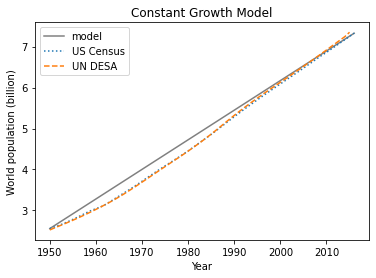

In [ ]:
results1.plot(label='model', color='gray',
              title='Constant Growth Model',legend=True)
plot_estimates()

It might not be obvious that using functions and a system object is a
big improvement, and for a simple model that we run only once, maybe
it's not. But as we work with more complex models, and when we run many simulations with different parameters, we'll see that this way of organizing the code makes a big difference.

Now let's see if we can improve the model.

---

## Proportional Growth Model

The biggest problem with the constant growth model is that it doesn't
make any sense. It is hard to imagine how people all over the world
could conspire to keep population growth constant from year to year.  

One way to understand why this model is faulty is to take it to extremes: if the world population were 7 million instead of 7 billion, it is impossible that the growth rate would still be 70 million people per year.

### Birth and death rates

It makes more sense to think of growth and decline in terms of *rates*: some percentage of the population will give birth each year, and a different percentage will die.

Let's create a new `run_simulation` function that computes the annual change in population according to birth and death rates.  Compare the difference between these two models:

In [ ]:
def run_simulation_lin(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        results[t+1] = results[t] + system['annual_growth']
    
    return results

def run_simulation_prop(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        births = system['birth_rate'] * results[t]
        deaths = system['death_rate'] * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

Each time through the loop, we use the parameter `birth_rate` to compute the number of births, and `death_rate` to compute the number of deaths.
The rest of the function is the same as `run_simulation_lin`.

Now we can choose the values of `birth_rate` and `death_rate` that best fit the data. 
For the death rate, I'll use 7.7 deaths per 1000 people, which was roughly the global death rate in 2020.

In [ ]:
system['death_rate'] = 7.7 / 1000

We'll choose a birth rate that matches are data.  If the birth rate were 7.7 births per 1000 people, what would happen to the population?

So that gives us a starting point.  Change the birth rate in the cell below, and rerun the model until it fits the data as closely as possible:

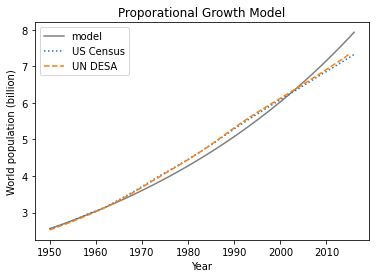

In [ ]:
system['birth_rate'] = 25 / 1000
results2 = run_simulation_prop(system)
results2.plot(label='model', color='gray',
              title='Proporational Growth Model',legend=True)
plot_estimates()

Depending on the birth rate we choose, we can get the model to fit the data in the first part of the time period, or we can get the model to match the current population, but doing both doesn't work. Overall,
the *quality of fit* is not as good as the constant growth model,
which is surprising, because it seems like the proportional model is
more realistic.

In the next chapter we'll try one more time to find a model that makes
sense and fits the data. But first, let's make a few more
improvements to the code.

### Adding flexibility by using a function as a parameter

`run_simulation_lin` and `run_simulation_prop` are nearly identical except for the body of the `for` loop, where we compute the population for the next year.

Rather than repeat identical code, we can separate the things that
change from the things that don't. First, I'll pull out the births and deaths from `run_simulation_prop` and make a function:

In [ ]:
def change_func_prop(t, pop, system):
    births = system['birth_rate'] * pop
    deaths = system['death_rate'] * pop
    return births - deaths

`change_func_prop` takes as arguments the current year, current population, and a `System` object; it returns the net population growth during the current year.

This function does not use `t`, so we could leave it out. But we will see other growth functions that need it, and it is convenient if they all take the same parameters, used or not.
Now we can write a function that runs any model:

In [ ]:
def run_simulation(system, change_func):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        growth = change_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

This function demonstrates a feature we have not seen before: it takes a
function as a parameter! When we call `run_simulation`, the second
parameter is a function, like `change_func_prop`, that computes the
population for the next year.

Here's how we call it:

In [ ]:
results = run_simulation(system, change_func_prop)

Passing a function as an argument is the same as passing any other
value. The argument, which is `change_func_prop` in this example, gets
assigned to the parameter, which is called `change_func`. Inside
`run_simulation`, we can call `change_func` just like any other function.

Each time through the loop, `run_simulation` calls `change_func_prop` to compute net growth, and uses it to compute the population during the next year.

### Combining Birth and Death

We can simplify the code slightly by combining births and deaths to compute the net growth rate. 
Instead of two parameters, `birth_rate` and `death_rate`, we can write the change function in terms of a single parameter that represents the difference:

In [ ]:
system['alpha'] = system['birth_rate'] - system['death_rate']

The name of this parameter, `alpha`, is the conventional name for a
proportional growth rate.

Here's the modified version of `change_func_prop`:

In [ ]:
def change_func_prop(t, pop, system):
    return system['alpha'] * pop

And here's how we run it:

In [ ]:
results = run_simulation(system, change_func_prop)

The results are the same as the previous versions, but now the code is organized in a way that makes it easy to explore other models.

<br>

---

## Summary and Exercises

In this chapter, we wrapped the code from the previous chapter in functions and used a `System` object to store the parameters of the system.

We explored a new model of population growth, where the number of births and deaths is proportional to the current population.  This model seems more realistic, but it turns out not to fit the data particularly well.

In the next chapter, we'll try one more model, which is based on the assumption that the population can't keep growing forever.

<br>

---

### Exercise 1

 Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an updated change function that takes `t`, `pop`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  The function should use `t` to determine which growth rate to use.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.

In [ ]:
# Create new growth function
def change_func_prop_change(t, pop, system):
    if t < 1980:
        alpha = system['alpha1']
    else:
        alpha = system['alpha2']
    return alpha * pop

In [ ]:
# Define the system and test the new function
system = dict(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth,
               alpha1 = 0.0185, alpha2 = 0.0148)
growth = change_func_prop_change(system['t_0'],system['p_0'],system)
print(growth)

0.047316130099


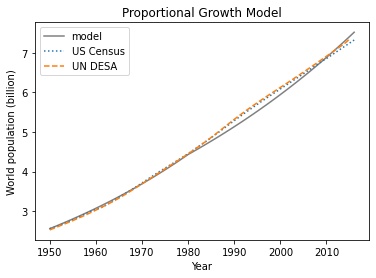

In [ ]:
# Run using run_simulation and plot results
results3 = run_simulation(system, change_func_prop_change)

results3.plot(label='model', color='gray', 
              title='Proportional Growth Model',
             legend=True)
plot_estimates()

### Exercise 2

We can get better results by changing our growth rate `alpha`.  But this is still a little disatisfying, right?  Why would the growth rate suddenly change in 1980?   

Try one more proportional change function here, but have the growth rate change gradually.  You can do this either by multiplication or subtraction.  There are numerous ways to code this, too.  Notice, though, that if you want to, you can permanantly update `system['alpha']` each time the change function using a line such as `system['alpha'] = system['alpha'] + 1`.

In [ ]:
# Create new growth function
def change_func_prop_frac(t, pop, system):
    system['alpha'] = system['alpha'] *  0.996
    return system['alpha'] * pop

def change_func_prop_sub(t, pop, system):
    system['alpha'] = system['alpha'] - 0.000065
    return system['alpha'] * pop

In [ ]:
# Define the system and test the new function
system = dict(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth,
               alpha = 0.0185)
growth = change_func_prop_sub(system['t_0'],system['p_0'],system)
print(growth)

0.047149884236490004


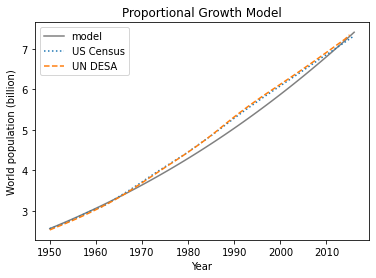

In [ ]:
# Run using run_simulation and plot results
results3 = run_simulation(system, change_func_prop_sub)

results3.plot(label='model', color='gray', 
              title='Proportional Growth Model',
             legend=True)
plot_estimates()